In [2]:
import sys
sys.path.append("../")
import tqdm
import time
import datetime
from datetime import datetime 
import random
import os
from os import listdir
from os.path import isfile, join
from torch.utils.data import DataLoader
from util import format_time, count_parameters, set_seed, collate_fn
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from exp import *
import numpy as np
import json
import sys
# from synonyms import *
import pickle
from timeline_construct import *
from ts import func, ModelWithTemperature
from functools import partial

In [4]:
num_dict = {0: "before", 1: "after", 2: "equal", 3: "vague"}

mask_in_input_ids = 0 # note that [MASK] is actually learned through pre-training
mask_in_input_mask = 0 # when input is masked through attention, it would be replaced with [PAD]
acronym = 0 # using acronym for tense (e.g., pastsimp): 1; else (e.g., past simple): 0
t_marker = 1


#############################
### Setting up parameters ###
#############################

f1_metric = 'micro'
params = {'transformers_model': 'google/bigbird-roberta-large',
          'dataset': 'MATRES' ,   # 'HiEve', 'IC', 'MATRES' 
          'testdata': 'None', # 
          'block_size': 64,
          'add_loss': 0, 
          'batch_size': 5,    # 6 works on 48G gpu. In the paper: 20 
          'accum_iter':1,
          'epochs': 0,
          'learning_rate': 0,    # subject to change
          'seed': 0,
          'debug': 0,
          'rst_file_name': 'init_test.rst',    # subject to change
          'mask_in_input_ids': mask_in_input_ids,
          'mask_in_input_mask': mask_in_input_mask,
          'marker': 'abc', 
          'tense_acron': 0, # 1 (acronym of tense) or 0 (original tense)
          't_marker': 1, # 2 (trigger enclosed by special tokens) or 1 (tense enclosed by **)
          'td': 0, # 0 (no tense detection) or 1 (tense detection, add tense info)
          'dpn': 0, # 1 if use DPN; else 0
          'lambda_1': -10, # lower bound * 10
          'lambda_2': 11, # upper bound * 10
          'f1_metric': f1_metric, 
         }
# $acr $tmarker $td $dpn $mask $lambda_1 $lambda_2

if params['testdata'] == 'MATRES_nd':
    params['nd'] = True
else:
    params['nd'] = False

if params['transformers_model'][-5:] == "large":
    params['emb_size'] = 1024
elif params['transformers_model'][-4:] == "base":
    params['emb_size'] = 768
else:
    print("emb_size is neither 1024 nor 768? ...")

set_seed(params['seed'])
rst_file_name = params['rst_file_name']


model_name = rst_file_name.replace(".rst", "")

cuda = torch.device('cuda')
params['cuda'] = cuda # not included in config file

#######################
### Data processing ###
#######################

print("Processing " + params['dataset'] + " dataset...")
t0 = time.time()
if params['dataset'] == "IC":
    dir_name = "./IC/IC_Processed/"
    #max_sent_len = 193
elif params['dataset'] == "HiEve":
    dir_name = "./hievents_v2/processed/"
    #max_sent_len = 155
elif params['dataset'] == "MATRES":
    dir_name = ""
else:
    print("Not supporting this dataset yet!")

tokenizer = AutoTokenizer.from_pretrained(params['transformers_model'])   
if acronym:
    special_tokens_dict = {'additional_special_tokens': 
                           [' [futuperfsimp]',' [futucont]',' [futuperfcont]',' [futusimp]', ' [pastcont]', ' [pastperfcont]', ' [pastperfsimp]', ' [pastsimp]', ' [prescont]', ' [presperfcont]', ' [presperfsimp]', ' [pressimp]', ' [futuperfsimppass]',' [futucontpass]',' [futuperfcontpass]',' [futusimppass]', ' [pastcontpass]', ' [pastperfcontpass]', ' [pastperfsimppass]', ' [pastsimppass]', ' [prescontpass]', ' [presperfcontpass]', ' [presperfsimppass]', ' [pressimppass]', ' [none]'
                           ]}
    spec_toke_list = []
    for t in special_tokens_dict['additional_special_tokens']:
        spec_toke_list.append(" [/" + t[2:])
    special_tokens_dict['additional_special_tokens'] += spec_toke_list
    num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
    model = AutoModel.from_pretrained(params['transformers_model'])
    model.resize_token_embeddings(len(tokenizer))
else:
    model = AutoModel.from_pretrained(params['transformers_model'])
params['model'] = model
debug = params['debug']
if debug:
    params['epochs'] = 1

model = model.to(cuda)



Processing MATRES dataset...


Some weights of the model checkpoint at google/bigbird-roberta-large were not used when initializing BigBirdModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
from model import transformers_mlp_cons

print(f'current device: { torch.cuda.current_device()}')

OnePassModel = transformers_mlp_cons(params)
OnePassModel.to(cuda)
OnePassModel.zero_grad()
print("# of parameters:", count_parameters(OnePassModel))




current device: 0
# of parameters: 364635144


In [8]:
state_dict = torch.load(best_PATH)
OnePassModel.load_state_dict(state_dict)
OnePassModel.eval()

In [58]:
from torch.nn import functional as F

model_losses = {}

for r in ["before", "after", "equal"]:

    features_eval = json.load(open(f"../data/flan_t5/{r}_features.json"))

    remove_list = ["being", "doing", "having", "'ve", "'re", "did", "'s", 
                   "are", "is", "am", "was", "were", "been", "had", "said", 
                   "be", "have", "can", "could", "may", "might", "must", "ought", "shall", "will", "would", "say", "nee", "need", "do", "happen", "occur"]

    eval_dataloader = DataLoader(features_eval, batch_size=5, shuffle=False, 
                                  collate_fn=partial(collate_fn, mask_in_input_ids=mask_in_input_ids, mask_in_input_mask=mask_in_input_mask), 
                                  drop_last=False)


    y_logits = np.array([[0, 0, 0, 0]])
    y_gold = []
    # load 
    for batch in eval_dataloader:
        with torch.no_grad():
            logits, loss = OnePassModel(batch[0].to(cuda), batch[1].to(cuda), batch[2], batch[3], batch[4], batch[5])
        # Move logits and labels to CPU

        labels = []
        for batch_label in batch[5]:
            for label in batch_label:
                labels.append(label)
        y_gold.extend(labels)

        y_logits = np.append(y_logits, logits.cpu().numpy(), 0) # for prediction result output # 3 if DPN; else 4
    y_logits = y_logits[1:]
    all_losses = F.cross_entropy(torch.tensor(y_logits), torch.tensor(y_gold), reduction="none")
    model_losses[r] = all_losses

In [72]:
# selection
selected_augmented_data = []
for r in ["before", "after", "equal"]:
    if r in ["before", "after"]:
        selected_idx = np.argsort(np.array(model_losses[r]))[:2500]
    else:
        selected_idx = np.argsort(np.array(model_losses[r]))[:1000]
    print(r, np.array(model_losses[r])[selected_idx[-1]])
    selected_augmented_data.extend( list(np.array(json.load(open(f"../data/flan_t5/{r}_features.json")))[selected_idx]) )

before 0.9138353400028479
after 2.805112340424625
equal 1.5301725379868791


In [74]:
with open('../data/flan_t5/aug_v1_6k', 'w') as writer:
    json.dump(selected_augmented_data, writer) 
len(selected_augmented_data)

6000

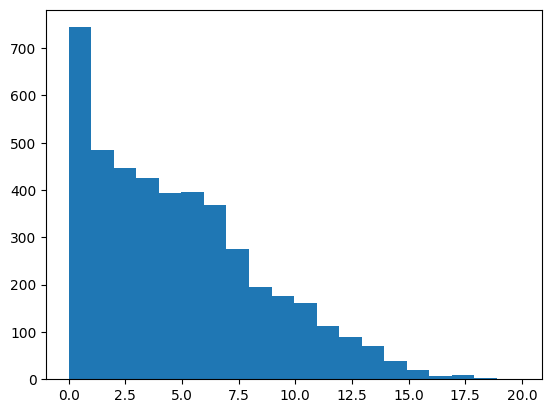

In [65]:
import matplotlib.pyplot as plt

plt.hist(all_losses, bins=20)
plt.show()

# check if the codes are correct using the original dev set

In [53]:
features_valid = json.load(open("../data/test_features_matres.json"))

remove_list = ["being", "doing", "having", "'ve", "'re", "did", "'s", 
               "are", "is", "am", "was", "were", "been", "had", "said", 
               "be", "have", "can", "could", "may", "might", "must", "ought", "shall", "will", "would", "say", "nee", "need", "do", "happen", "occur"]

valid_dataloader = DataLoader(features_valid, batch_size=5, shuffle=False, 
                              collate_fn=partial(collate_fn, mask_in_input_ids=mask_in_input_ids, mask_in_input_mask=mask_in_input_mask), 
                              drop_last=False)


In [54]:
y_logits = np.array([[0, 0, 0, 0]])
y_gold = []
y_pred = []
# load 
for batch in valid_dataloader:
    with torch.no_grad():
        logits, loss = OnePassModel(batch[0].to(cuda), batch[1].to(cuda), batch[2], batch[3], batch[4], batch[5])
    # Move logits and labels to CPU
    
    y_predict = torch.max(logits, 1).indices.cpu().numpy()
    y_pred.extend(y_predict)
    
    labels = []
    for batch_label in batch[5]:
        for label in batch_label:
            labels.append(label)
    y_gold.extend(labels)

    y_logits = np.append(y_logits, logits.cpu().numpy(), 0) # for prediction result output # 3 if DPN; else 4
y_logits = y_logits[1:]

In [55]:
from sklearn.metrics import f1_score
f1_score(y_gold, y_pred, average='micro')

0.6968215158924206

In [56]:
len(y_logits)

818

In [48]:
dev_losses = F.cross_entropy(torch.tensor(y_logits), torch.tensor(y_gold), reduction="none")

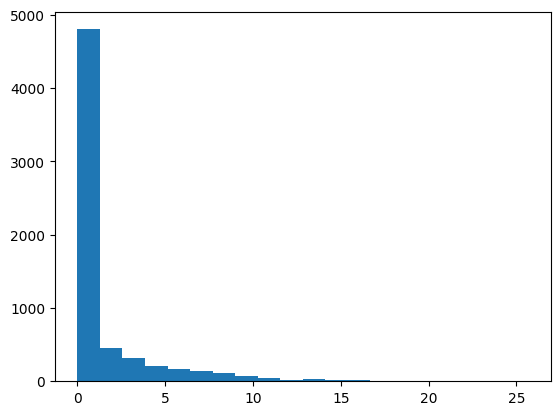

In [64]:
import matplotlib.pyplot as plt

plt.hist(dev_losses, bins=20)
plt.show()

In [60]:
dev_losses[:10]

tensor([9.3306e-06, 3.2434e-04, 5.2555e+00, 2.7464e-01, 2.0245e+00, 5.2814e-01,
        6.2831e-04, 1.7468e-01, 4.0698e-04, 6.5087e-01], dtype=torch.float64)